# ANALYSIS OF SPAIN DEMOGRAPHIC DATA - PART III

## Introduction

This work aims to continue analyzing, via python, the demographic data of __INE - Instituto Nacional de Estadística de España__. This time we are going to use the library related to maps of Spain, which is **folium**.

Thus, the first instruction proposes to highlight the map of Spain on the screen. For this, it is necessary to know the geographic coordinates of a central point in Spain for such observation. Observing it in **Google Maps**, you get an apparently central point that has the following coordinates:

- **40°06'00.0"N 3°30'00.0"W**, which is the format of Degrees, Minutes and Seconds (DDDº MM'SS''), remembering that the order of presentation is latitude and longitude.
- **40.100000, -3.500000**, which is the format of Degrees and Decimals of Degree (DDDºDDDDD) , and which is the **most common and most used**.

So this last format is what you find in most computer-based mapping systems. Coordinates are stored like this, as there is no need to convert to radians. Often North-South or East-West orientation.

Positive Latitude values ​​are north of the equator, negative values ​​are south.

With longitude, negative values ​​are for West and positive for East, considering the zero point in Greenwich, England.

Another thing is that the longitude field needs **3 places** before the comma or period, as it can reach 180º, while Latitude only needs **two places**, because it goes up to 90º.

Let's draw up a specific map of Spain, using folium:



In [1]:
import folium
# definir o mapa da espanha
espanha_map = folium.Map(location=[40.10, -3.5], zoom_start=6,tiles='Stamen Terrain')

# display o mapa da espanha
espanha_map

We are now going to prepare maps of the Choropleth type, where the intention is to visually highlight the autonomous communities on the map of Spain, considering the number of inhabitants. That is, the map will show __ with darker colors__, the autonomous communities __more populous__ and with __lighter colors__ the autonomous communities __less populous__. Choropleth has 3 color options which are: Divergent, Sequential and Qualitative. Extracted from a website $https://github.com/python-visualization/folium/issues/403$, we have the following extract from the figure:
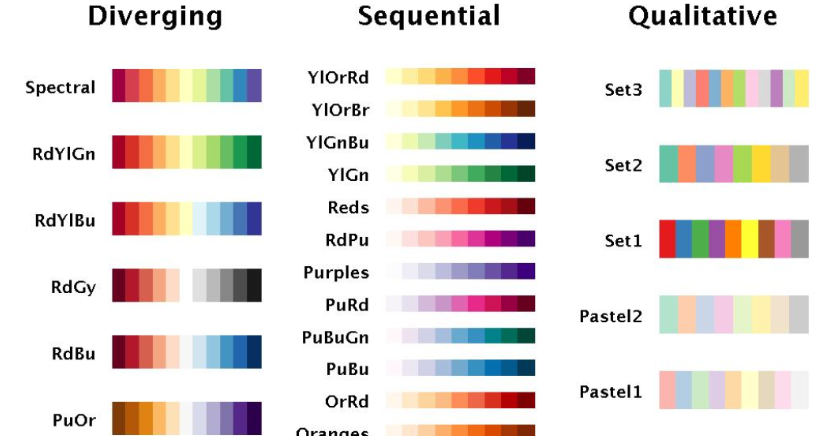

For the map in question, I'm going to use the **Sequential** category and so I'm going to put **fill_color='Reds'**.

However, first I will import the Geojson file that will work on the contours of the autonomous communities in Spain and that will make it possible to establish the sequence of colors that will identify the population level of the communities.

In [4]:
import urllib.request, json 
with urllib.request.urlopen("https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/spain-communities.geojson") as url:
    data = json.load(url)
    

Now, let's move on to the following phases:
- Import of data already refined and stored locally and represented by **dfs1240cc** and composed of 4 columns: index, REGION, POPULATION, HABIT RATE(%).
- First delimitation of the data in **dfs1240dd** which is composed of 3 columns: index, REGION, POPULATION.
- Transformation of the values of the 'index' column into a string and with complementation in the one-digit codes, such as '3', to a 2-digit code such as '03', adding a zero.
- Changing the name of the column 'index' to 'COD'.
- Division of 'POPULATION' values by one million.

To take these actions and others, it is worth observing the composition of the Geojson file, as in the following figure:
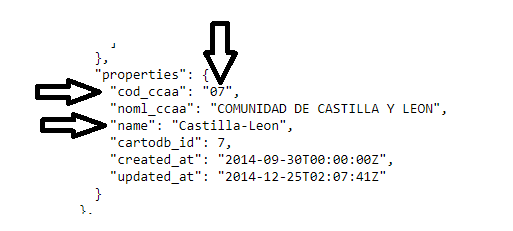

This way, based on the extract above, you get **key_on='properties.cod_ccaa'**, which also shows the two-digit pattern, in addition to the autonomous community name in **'name'**.

In [7]:
import urllib.request
import pandas as pd
import requests
import os
import folium
import json
import shutil
dfs1240cc = pd.read_csv('dfs1240bb.csv')
dfs1240dd= dfs1240cc.iloc[1:20,0:3]
dfs1240dd.to_csv('dfs1240dd.csv',index=False)

for s in range(len(dfs1240dd)):
    if dfs1240dd.iloc[s,0]  < 10:
        dfs1240dd.iloc[s,0]=str(dfs1240dd.iloc[s,0])
        dfs1240dd.iloc[s,0]='0'+dfs1240dd.iloc[s,0]
    elif dfs1240dd.iloc[s,0] >=10:
        dfs1240dd.iloc[s,0]=str(dfs1240dd.iloc[s,0])
        
dfs1240dd.rename(columns={'index':'COD'},inplace=True) 
dfs1240dd['POPULAÇÃO'] = (dfs1240dd['POPULAÇÃO'] / 1000000).round(2)
dfs1240dd.to_csv('dfs1240dd.csv',index=False)

mapa_espanha = folium.Map([40.10, -3.5], zoom_start=6,tiles='stamenwatercolor')

# adicionando-se 'tile layers' para o mapa
tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']
for tile in tiles:
    folium.TileLayer(tile).add_to(mapa_espanha)



choropleth = folium.Choropleth(data,
    fill_opacity=1,
    line_opacity=1,
    data=dfs1240dd ,
    columns=['COD', 'POPULAÇÃO'],
    key_on='properties.cod_ccaa',
    fill_color='Reds',
    
    bins=[0,2,4,6,8,10],
   legend_name='Habitantes nas Comunidades Autônomas da Espanha(x milhão)',
   highlight=True 
).add_to(mapa_espanha)

style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'], style=style_function, labels=False))

folium.LayerControl().add_to(mapa_espanha)

mapa_espanha

In [8]:
dfs1240cc.head()

,index,REGIÃO,POPULAÇÃO,TAXA HABIT(%).
0,0,Total Nacional,47432805,100.00
1,1,01 Andalucía,8518053,17.96
2,9,09 Cataluña,7679410,16.19
3,13,"13 Madrid, Comunidad de",6769113,14.27
4,10,10 Comunitat Valenciana,5072176,10.69


Looking at the map and the color sequence, it can be seen that Andalucia, followed by Catalunha and Madrid are the most populous. It is even worth comparing with the **dfs1240dd** dataframe itself shown below. Also notice that the legend shows the color gradient with a scale that goes from 0 to 10, which is multiplied by a million. Hovering the mouse over it displays the name of the communities:

In [9]:
dfs1240dd.head()


,COD,REGIÃO,POPULAÇÃO
1,01,01 Andalucía,8.52
2,09,09 Cataluña,7.68
3,13,"13 Madrid, Comunidad de",6.77
4,10,10 Comunitat Valenciana,5.07
5,12,12 Galicia,2.69


We are now going to do a task that consists of preparing a **dfs1240k** dataframe to create a choropleth theme with autonomous communities addressing **Demographic Density** or **Hab/km<sup>2</sup>**. To do so, we will use the data from the site:

               https://www.ign.es/web/ign/portal/ane-datos-geograficos/-/datos-geograficos/datosPoblacion?tipoBusqueda=CCAA"
               
The data are shown in the following figure, taken from the aforementioned website:
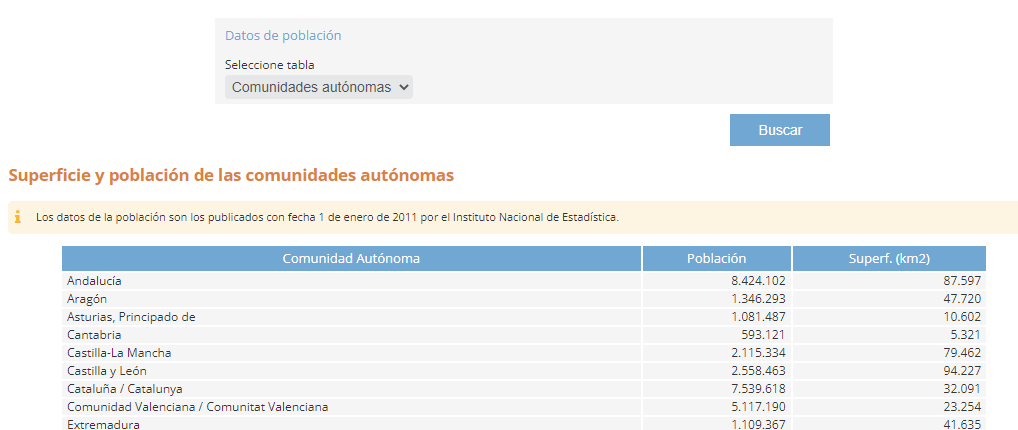

This data is available in HTML format and thus an extraction was performed using **BeautifulSoup**. In preparing this data, the following actions were taken:

- Extraction of HTML data, creating **dfs1240k**.
- Change in the name of the column Comunidad Autónoma to COMAUT in **dfs1240k**.
- **"For"** to strip the points from the values ​​in the Población column in **dfs1240k**, in addition to converting 'str' to 'float' and then to 'int'.
- **"For"** to strip the points from the values in the 'Superf. (km2)' and multiply the values by 1000 in **dfs1240k**.
- Changing the name of the 'Superf column. (km2)' for SUPERF, as the old name was a lot of work with encoding in **dfs1240k**.
- Code column creation with empty values in **dfs1240k**.
- "For" to fill the code column in dfs1240k, with the values extracted from **dfs1240dd**.

This is a demonstration of the importance and complexity of debugging raw data for later use. One of the difficulties was that in a dataframe, the **dfs1240k**, the names of the Autonomous Communities, differed from the names of the Autonomous Communities in the dataframe **dfs1240dd**, which led to having to use the **str.contains( )**, but even so we had to change the name of some communities so that they would be minimally __'standardized'__.

In [10]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

#Extração dos dados HTML

url_estatica12 = "https://www.ign.es/web/ign/portal/ane-datos-geograficos/-/datos-geograficos/datosPoblacion?tipoBusqueda=CCAA"

resposta_scrap = requests.get(url_estatica12)

soup = BeautifulSoup(resposta_scrap.content,'html5lib' )

html_tables = soup.find_all('table')

tabela1 = html_tables[1]

column = tabela1.find_all("th")

column0 = tabela1.find_all("th")[0]
column1 = tabela1.find_all("th")[1]
column2 = tabela1.find_all("th")[2]


pagina12 = requests.get(url_estatica12)
soup = BeautifulSoup(pagina12.text, 'html5lib')

dfs1240x = pd.read_html(pagina12.text)
dfs1240k = dfs1240x[1]

# Alteração no nome da coluna Comunidad Autónoma para COMAUT

dfs1240k.rename(columns={'Comunidad Autónoma':'COMAUT'},inplace=True)

# Um "for" para retirar os pontos dos valores na coluna Población, além da trasnformação em int
aa=0
bb=0
cc=0
for l in range(len(dfs1240k)):
    aa=dfs1240k.iloc[l,1]
    bb=aa.replace('.','')
    cc=int(float(bb))
    dfs1240k.iloc[l,1]=cc

# Um "for" para retirar os pontos dos valores na coluna Superf. (km2) e multiplicar os valores por 1000
    
aaa=0
bbb=0
ccc=0
for l in range(len(dfs1240k)):
    aaa=dfs1240k.iloc[l,2]
    bbb=aaa*1000
    dfs1240k.iloc[l,2]=bbb
  
# Alteração da coluna Población para int    
    
dfs1240k['Población'] = dfs1240k['Población'].astype(int) 

# Alteração do nome da coluna Superf. (km2) para SUPERF, pois o nome antigo dava muito trabalho com encoding
 
dfs1240k.columns.values[2] = "SUPERF"

# Criação da coluna Código com valores vazios

dfs1240k['Código']=''

# Criação da coluna Hab/Km2 com os valores da divisão entre Población e SUPERF

dfs1240k['Hab/Km2']= (dfs1240k['Población']/dfs1240k['SUPERF']).round(2)

# For para preencher a coluna código com os valores extraídos do dfs1240dd
d = 0
e = 0
f = 0
dfs1240k.iloc[17,0]='Ceuta'
dfs1240k.iloc[18,0]='Melilla'
dfs1240k.iloc[7,0]='Valencia'
dfs1240k.iloc[4,0]='La Mancha'

for m in range(len(dfs1240k)):
    d = dfs1240k.iloc[m].COMAUT[0:8]
    e = dfs1240dd[dfs1240dd['REGIÃO'].str.contains(d)]
    
    f = e.iloc[0,0]
    dfs1240k.iloc[m,3] = f

dfs1240k.sort_values(by=['Hab/Km2'],ascending=False,inplace=True)
    
dfs1240k.head(7)


,COMAUT,Población,SUPERF,Código,Hab/Km2
10,"Madrid, Comunidad de",6489680,8028.0,13,808.38
13,País Vasco / Euskadi,2184606,7230.0,16,302.16
16,Canarias,2126769,7447.0,05,285.59
6,Cataluña / Catalunya,7539618,32091.0,09,234.94
15,"Balears, Illes",1113114,4992.0,04,222.98
7,Valencia,5117190,23254.0,10,220.06
11,"Murcia, Región de",1470069,11314.0,14,129.93


Let's then elaborate the Choropleth graph, focusing on the Demographic Density in the Autonomous Communities, which is **Inhabitants/km<sup>2</sup>**:

In [11]:
import folium
import urllib.request, json 
with urllib.request.urlopen("https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/spain-communities.geojson") as url:
    data1 = json.load(url)

mapa_espanha1 = folium.Map([40.10, -3.5], zoom_start=6,tiles='stamenwatercolor')

# adicionando-se 'tile layers' para o mapa
tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']
for tile in tiles:
    folium.TileLayer(tile).add_to(mapa_espanha1)



choropleth = folium.Choropleth(data1,
    fill_opacity=1,
    line_opacity=1,
    data=dfs1240k ,
    columns=['Código', 'Hab/Km2'],
    key_on='properties.cod_ccaa',
    fill_color='Oranges',
    
    bins=[0,100,200,300,400,500,600,700,800,900],
   legend_name='Densidade Demográfica nas Comunidades Autônomas da Espanha(Hab/Km2)',
   highlight=True 
).add_to(mapa_espanha1)

style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'], style=style_function, labels=False))

folium.LayerControl().add_to(mapa_espanha1)

mapa_espanha1

Looking at it, it is verified that Madrid has the highest population density, followed by País Vasco, Canary Islands, Catalonia, Balearic Islands and Valencia. The islands, due to the fact that they have little surface, extrapolate from the context. Thus, the aforementioned Communities with a higher population density stand out, but a large majority of communities with very low population density, but having to take into account the rural areas that naturally have very low population density. It is important to emphasize that vision is not very accurate by colors to perceive subtle differences in population. More abrupt differences are noticed.

In [ ]:
dfs1240k.head(10)

Let's now act on the folium map, without involving choropleth. For this we will generate a **dfs1241k** dataframe, based on the site:

        https://www.ign.es/web/ign/portal/ane-datos-geograficos/-/datos-geograficos/datosPoblacion?tipoBusqueda=capitales
            
The data are as shown in the figure below:

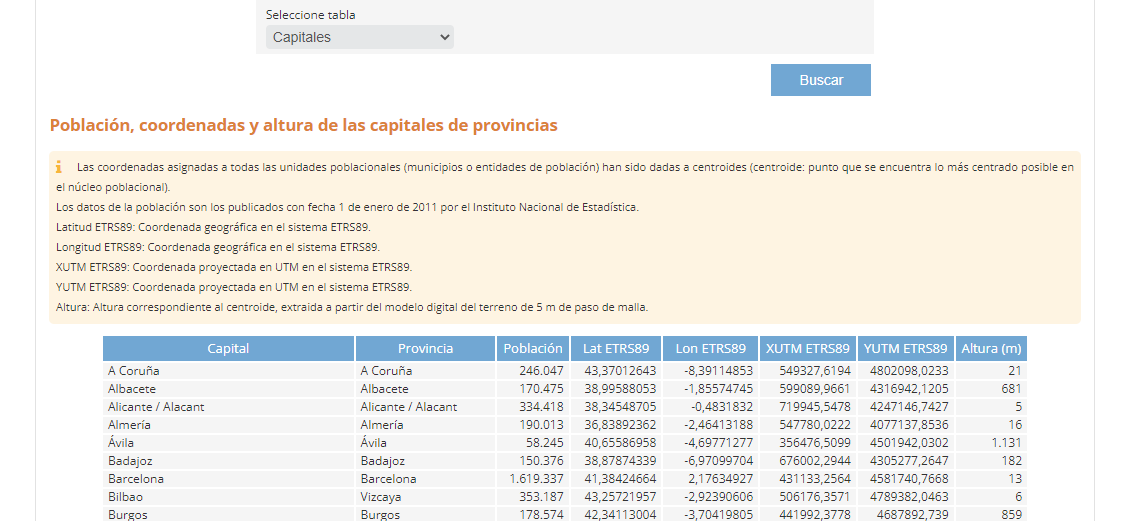
    

In [15]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

url_estatica13 = "https://www.ign.es/web/ign/portal/ane-datos-geograficos/-/datos-geograficos/datosPoblacion?tipoBusqueda=capitales"
resposta_scrap = requests.get(url_estatica13)


soup = BeautifulSoup(resposta_scrap.content,'html5lib' )

html_tables = soup.find_all('table')

tabela2 = html_tables[1]
column = tabela2.find("th")

pagina13 = requests.get(url_estatica13)
soup = BeautifulSoup(pagina13.text, 'html5lib')

dfs1241x = pd.read_html(pagina13.text,decimal=',', thousands='.')
dfs1241k = dfs1241x[1]
dfs1241k.drop(['Población','XUTM ETRS89','YUTM ETRS89','Altura (m)'],axis=1,inplace = True)
dfs1241k['Código']=''
dfs1241k.columns.values[2] = "Lat"
dfs1241k.columns.values[3] = "Lon"
dfs1241k['Pop2021']=0.0

dfs1241k.head()



,Capital,Provincia,Lat,Lon,Código,Pop2021
0,A Coruña,A Coruña,43.370126,-8.391149,,0.0
1,Albacete,Albacete,38.995881,-1.855747,,0.0
2,Alicante / Alacant,Alicante / Alacant,38.345487,-0.483183,,0.0
3,Almería,Almería,36.838924,-2.464132,,0.0
4,Ávila,Ávila,40.655870,-4.697713,,0.0


Vamos criar outro dataframe, o **dfs1246x** com os dados ds províncias e seus códigos, gerados a partir do site:

                https://www.ine.es/daco/daco42/codmun/cod_provincia.htm

O objetivo é buscar os dados de código e preencher no **df1241x**.

In [16]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd


url_estatica14 = "https://www.ine.es/daco/daco42/codmun/cod_provincia.htm"
resposta_scrap = requests.get(url_estatica14)

soup = BeautifulSoup(resposta_scrap.content,'html5lib' )

html_tables = soup.find_all('table')

pagina14 = requests.get(url_estatica14)
soup = BeautifulSoup(pagina14.text, 'html5lib')

dfs1242x = pd.read_html(pagina14.text,decimal=',', thousands='.')
dfs1243x = dfs1242x[1]
dfs1244x = dfs1242x[2]
dfs1245x = dfs1242x[3]
dfs1246x = pd.concat([dfs1243x,dfs1244x,dfs1245x],axis=0)
dfs1246x.rename(columns = {'Literal':'Provincia'}, inplace = True)
dfs1246x.reset_index(drop=True,inplace=True)
dfs1246x.iloc[9,1]='Vizcaya'
dfs1246x.iloc[35,1]='Las Palmas'
dfs1246x.iloc[37,1]='La Rioja'
dfs1246x.iloc[7,1]='Illes Balears'

dfs1246x.head()

,Código,Provincia
0,2,Albacete
1,3,Alicante/Alacant
2,4,Almería
3,1,Araba/Álava
4,33,Asturias


The **"For"** below associates the provinces between **dfs1241x** and **dfs1246x** and fills in the code in **dfs1241x**. It was necessary to apply a "work around" to correct some provinces due to some limitations of **str.contains()**, but which is fundamental for learning:

In [19]:
a = 0
b = 0
c = 0

for g in range(len(dfs1241k)):
    a = dfs1241k.iloc[g].Provincia[2:7]
    b = dfs1246x[dfs1246x['Provincia'].str.contains(a)]
    c = b.iloc[0,0]
    dfs1241k.iloc[g,4] = c

dfs1241k.iloc[43,4]=42
dfs1241k.iloc[26,4]=27
dfs1241k.iloc[23,4]=24
dfs1241k.iloc[47,4]=46
dfs1241k.head()

,Capital,Provincia,Lat,Lon,Código,Pop2021
0,A Coruña,A Coruña,43.370126,-8.391149,15,0.0
1,Albacete,Albacete,38.995881,-1.855747,2,0.0
2,Alicante / Alacant,Alicante / Alacant,38.345487,-0.483183,3,0.0
3,Almería,Almería,36.838924,-2.464132,4,0.0
4,Ávila,Ávila,40.655870,-4.697713,5,0.0


The following "For" pads 1-digit numbers with leading zeros, for example: from **4 to 04**. 2-digit numbers remain as they are, for example: from **15 to 15**.

In [20]:
for s in range(len(dfs1241k)):
    if dfs1241k.iloc[s,4]  < 10:
        dfs1241k.iloc[s,4]=str(dfs1241k.iloc[s,4])
        dfs1241k.iloc[s,4]='0'+dfs1241k.iloc[s,4]
    elif dfs1241k.iloc[s,4] >=10:
        dfs1241k.iloc[s,4]=str(dfs1241k.iloc[s,4])
        

dfs1241k.head(5)

,Capital,Provincia,Lat,Lon,Código,Pop2021
0,A Coruña,A Coruña,43.370126,-8.391149,15,0.0
1,Albacete,Albacete,38.995881,-1.855747,02,0.0
2,Alicante / Alacant,Alicante / Alacant,38.345487,-0.483183,03,0.0
3,Almería,Almería,36.838924,-2.464132,04,0.0
4,Ávila,Ávila,40.655870,-4.697713,05,0.0


Now let's download the data from the following site:

                 "https://www.ine.es/jaxiT3/files/t/es/xlsx/2853.xlsx?nocab=1"

The objective is to get the population data in **dfs402**, which should be loaded in the **Pop2021** column of **dfs1241k** dataframe.
That is, **dfs1241k** is the final product of these operations.

In [21]:
url80_estatica="https://www.ine.es/jaxiT3/files/t/es/xlsx/2852.xlsx?nocab=1"

dfs400 = pd.read_excel(url80_estatica, header=None,skiprows=[0,1,2,3,4,5,6,7,8])
dfs401=dfs400.iloc[0:52,0:2]
l1=[]
l2=[]
l1=dfs401[0].tolist()
l2=dfs401[1].tolist()
dict6={'Provincias':l1,'População':l2}
dfs402=pd.DataFrame(dict6)
dfs402.head()

,Provincias,População
0,02 Albacete,386464.0
1,03 Alicante/Alacant,1881762.0
2,04 Almería,731792.0
3,01 Araba/Álava,333626.0
4,33 Asturias,1011792.0


Let's fill in the data from **dfs402** in column **Pop2021 **in **dfs1241k**.

In [22]:
aaa = 0
bbb = 0
ccc = 0

for s in range(len(dfs1241k)):
    aaa = dfs1241k.iloc[s].Código
    bbb = dfs402[dfs402['Provincias'].str.contains(aaa)]
    ccc = bbb.iloc[0,1]
    dfs1241k.iloc[s,5] = ccc
dfs1241k.to_csv('dfs1241k.csv',index=False)

dfs1241k.head(5)

,Capital,Provincia,Lat,Lon,Código,Pop2021
0,A Coruña,A Coruña,43.370126,-8.391149,15,1120134.0
1,Albacete,Albacete,38.995881,-1.855747,02,386464.0
2,Alicante / Alacant,Alicante / Alacant,38.345487,-0.483183,03,1881762.0
3,Almería,Almería,36.838924,-2.464132,04,731792.0
4,Ávila,Ávila,40.655870,-4.697713,05,158421.0


In order to circumvent some limitations in the "popup" on the map below, with information on capitals and provinces, we are going to create a **dfs1241m** dataframe that will facilitate the dissemination of information on the map.

In [25]:
dfs1241m=dfs1241k[['Código','Capital','Provincia','Pop2021']]
dfs1241m=dfs1241m.astype(str)
dfs1241m['Código'] = 'Codigo: ' + dfs1241m['Código']
dfs1241m['Capital'] = 'Capital: ' + dfs1241m['Capital']
dfs1241m['Provincia'] = 'Provincia :' + dfs1241m['Provincia']
dfs1241m['Pop2021'] = 'Habitantes na Provincia:' + dfs1241m['Pop2021']
dfs1241m.head()

,Código,Capital,Provincia,Pop2021
0,Codigo: 15,Capital: A Coruña,Provincia :A Coruña,Habitantes na Provincia:1120134.0
1,Codigo: 02,Capital: Albacete,Provincia :Albacete,Habitantes na Provincia:386464.0
2,Codigo: 03,Capital: Alicante / Alacant,Provincia :Alicante / Alacant,Habitantes na Provincia:1881762.0
3,Codigo: 04,Capital: Almería,Provincia :Almería,Habitantes na Provincia:731792.0
4,Codigo: 05,Capital: Ávila,Provincia :Ávila,Habitantes na Provincia:158421.0


Let's create the folium map **espanha_map** with all the expected feature0. It is necessary **to click** with the mouse on the symbols.It's the end result:

In [26]:
import folium

espanha_map = folium.Map(location=[40.10, -3.5], zoom_start=6,tiles='Stamenterrain')


title_html = '''
             <h3 align="center" style="font-size:20px"><b>QTDE DE HABITANTES NAS PROVÍNCIAS ESPANHOLAS</b></h3>
             '''
espanha_map.get_root().html.add_child(folium.Element(title_html))

# instanciando um feature group para as provincias no dataframe
Provincias = folium.map.FeatureGroup()




# Atuando pelas 52 provincias e adicionando as informações para cada provincia do feature group
for lat, lng, in zip(dfs1241k.Lat, dfs1241k.Lon):
    Provincias.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# adicionando texto de pop-up para cada marker no mapa
latitudes = list(dfs1241k.Lat)
longitudes = list(dfs1241k.Lon)
labels = dfs1241m.values.tolist()


for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(espanha_map)        
    
# adicionando provincias no mapa
espanha_map.add_child(Provincias)

## Conclusions:

And so we end Part III. In this jupyter notebook, I explored the use of **Folium Maps** which offers a very interesting visual option for presentations, through maps. It is noteworthy that through python codes, an option can be offered in a language that is well understood by the decision-making stakeholders.

It is very evident that it is an interesting subject to develop learnings about Data Science solutions.



